In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers, models
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.utils import to_categorical,split_dataset
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns; sns.set()
import pandas as pd
from collections import Counter
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow.python.keras.backend as K
from tensorflow.keras.models import clone_model
from datetime import datetime

In [2]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(50000, 32, 32, 3)

(50000, 1)

(10000, 32, 32, 3)

(10000, 1)

In [4]:
# Standardizing (255 is the total number of pixels an image can have)
X_test = X_test / 255 
X_train = X_train / 255

# One hot encoding the target class (labels)
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

In [6]:
print(X_train)
print(y_train)
print(X_valid)
print(X_test.shape)
print(y_test.shape)

[[[[0.03921569 0.03921569 0.03921569]
   [0.07843137 0.07843137 0.07843137]
   [0.03529412 0.03529412 0.03529412]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.01176471 0.01176471 0.01176471]
   [0.02745098 0.02745098 0.02745098]
   [0.03921569 0.03921569 0.03921569]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.01176471 0.01176471 0.01176471]
   [0.00784314 0.00784314 0.00784314]
   [0.01960784 0.01960784 0.01960784]
   ...
   [0.00784314 0.         0.        ]
   [0.00392157 0.         0.        ]
   [0.00392157 0.         0.        ]]

  ...

  [[0.07058824 0.05882353 0.02745098]
   [0.22745098 0.19607843 0.12941176]
   [0.35294118 0.29411765 0.19215686]
   ...
   [0.00784314 0.         0.00392157]
   [0.00784314 0.         0.        ]
   [0.00784314 0.         0.        ]]

  [[0.03921569 0.01568627 0.00784314]
   [0.0

In [14]:
def resnet_block(x, filters, kernel_size=3, stride=1, downsample=False):
    # Identity path
    shortcut = x

    # First convolutional layer in the block
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer in the block
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Downsampling shortcut if necessary
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Adding the shortcut connection
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

def create_resnet18(lr = 0.01, optimizer = 'sgd', dropout = 0):
    inputs = layers.Input(shape=(32, 32, 3))

    # Initial Conv layer
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks for each stage
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, stride=2, downsample=True)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, stride=2, downsample=True)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, stride=2, downsample=True)
    x = resnet_block(x, 512)

    # Global Average Pooling and Dense output layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    resnet18_model = models.Model(inputs=inputs, outputs=outputs)

    
    # Compile the model
    if optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=lr)
    elif optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    resnet18_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Print model summary (optional)
    # resnet18_model.summary()
    return resnet18_model



# Train VGG16

# VGG16 with or without Image Augmentation

In [8]:
augmentations = [
    {
        'rotation_range':15,
        'horizontal_flip': True,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
     },
    {},
]

# Data to store results for plotting
results = {
    'epoch': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss':[],
    'model': []
}

# Track model names for each augmentation stage
model_names = {
    0: 'ResNet18 ImageAugmentation',
    1: 'ResNet18 No Augmentation',
}

# Training loop adding one augmentation at a time
for i, aug_config in enumerate(augmentations):
    model_name = model_names[i]
        
    datagen = ImageDataGenerator(**aug_config)
    print(f"{i}. Training with augmentations: {aug_config}")
    
    cnn_resnet18_model = create_resnet18()
    epoch_val = 100
    
    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
    mcp_save = keras.callbacks.ModelCheckpoint(f'./resnet18_model_{model_name}.keras', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-2, mode='min')
    

    history_img_aug = cnn_resnet18_model.fit(
        datagen.flow(X_train,y_train, batch_size=64),
        batch_size=64,
        epochs=epoch_val,
        validation_data=(X_valid, y_valid),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
    )

    # Record results for each epoch
    for epoch in range(len(history_img_aug.history['accuracy'])):
        results['epoch'].append(epoch)
        results['train_accuracy'].append(history_img_aug.history['accuracy'][epoch])
        results['val_accuracy'].append(history_img_aug.history['val_accuracy'][epoch])
        results['train_loss'].append(history_img_aug.history['loss'][epoch])
        results['val_loss'].append(history_img_aug.history['val_loss'][epoch])
        results['model'].append(model_name)

# Convert results to a DataFrame
val_result_img_aug = pd.DataFrame(results)

0. Training with augmentations: {'rotation_range': 15, 'horizontal_flip': True, 'width_shift_range': 0.1, 'height_shift_range': 0.1}


2024-11-09 19:38:25.173919: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-11-09 19:38:25.174020: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-09 19:38:25.174040: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-09 19:38:25.174352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-09 19:38:25.174396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,864 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,864 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,864 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 11,183,562 (42.66 MB)

 Trainable params: 11,173,962 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/100


2024-11-09 19:38:27.867432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/bernardjohari/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 128ms/step - accuracy: 0.3560 - loss: 1.7686 - val_accuracy: 0.3998 - val_loss: 1.6899 - learning_rate: 0.0100
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.5268 - loss: 1.3028 - val_accuracy: 0.5105 - val_loss: 1.4566 - learning_rate: 0.0100
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.5854 - loss: 1.1512 - val_accuracy: 0.5899 - val_loss: 1.1826 - learning_rate: 0.0100
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.6321 - loss: 1.0336 - val_accuracy: 0.6330 - val_loss: 1.0256 - learning_rate: 0.0100
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 126ms/step - accuracy: 0.6678 - loss: 0.9301 - val_accuracy: 0.5347 - val_loss: 1.4642 - learning_rate: 0.0100
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 119ms/step - accuracy: 0.6970 - loss: 0.8542 - val_accuracy: 0.6656 - val_loss: 0.9917 - learning_rate: 0.0100
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.7181 -

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │      1,728 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_17[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 32, 32,    │          0 │ add_8[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_19[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,864 │ re_lu_20[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 11,183,562 (42.66 MB)

 Trainable params: 11,173,962 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 115ms/step - accuracy: 0.3722 - loss: 1.7134 - val_accuracy: 0.4515 - val_loss: 1.5043 - learning_rate: 0.0100
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.5815 - loss: 1.1730 - val_accuracy: 0.5419 - val_loss: 1.2881 - learning_rate: 0.0100
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.6852 - loss: 0.8884 - val_accuracy: 0.5273 - val_loss: 1.4376 - learning_rate: 0.0100
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7735 - loss: 0.6650
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.7735 - loss: 0.6650 - val_accuracy: 0.5561 - val_loss: 1.3630 - learning_rate: 0.0100
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.8833 - loss: 0.4004 - val_accuracy: 0.6989 - val_loss: 0.8634 - learning_rate: 1.0000e-03
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accur

In [10]:
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
val_result_img_aug.to_csv(f'resnet18_val_result_img_aug_{current_datetime}.csv', index=False)
display(val_result_img_aug)

,epoch,train_accuracy,val_accuracy,train_loss,val_loss,model
0,0,0.424850,0.3998,1.573581,1.689950,ResNet18 ImageAugmentation
1,1,0.539300,0.5105,1.272779,1.456592,ResNet18 ImageAugmentation
2,2,0.595575,0.5899,1.123842,1.182578,ResNet18 ImageAugmentation
3,3,0.641175,0.6330,1.011098,1.025642,ResNet18 ImageAugmentation
4,4,0.672425,0.5347,0.919361,1.464236,ResNet18 ImageAugmentation
5,5,0.701050,0.6656,0.842565,0.991695,ResNet18 ImageAugmentation
6,6,0.723300,0.7026,0.776043,0.857683,ResNet18 ImageAugmentation
7,7,0.742550,0.7312,0.728166,0.777590,ResNet18 ImageAugmentation
8,8,0.760575,0.7387,0.683093,0.761394,ResNet18 ImageAugmentation
9,9,0.774350,0.7354,0.639827,0.771162,ResNet18 ImageAugmentation


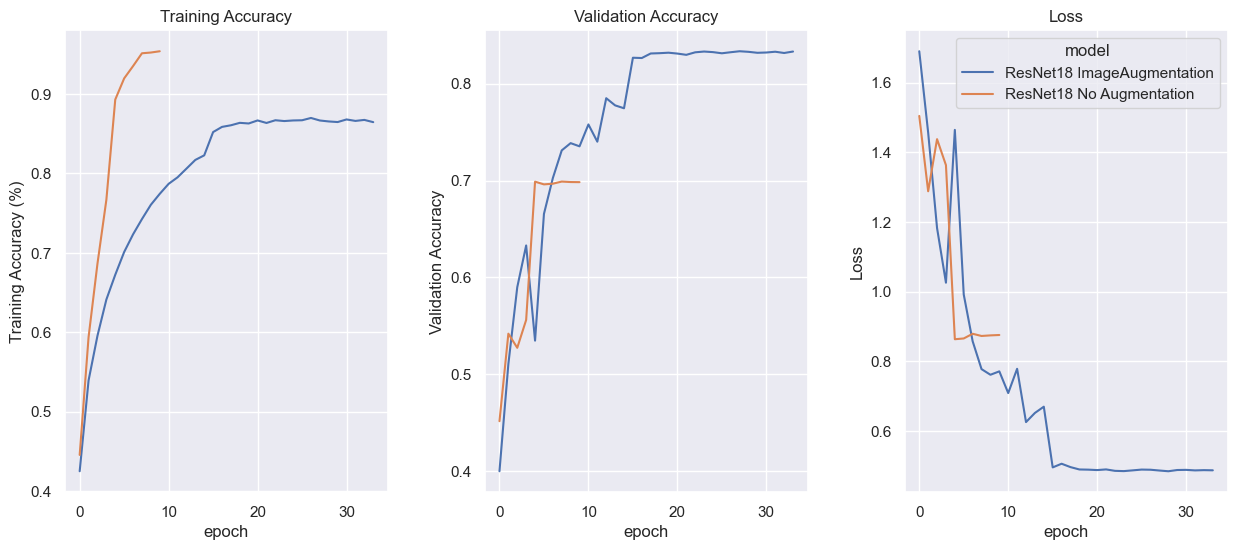

In [11]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Define model order for consistent hue ordering
model_order = list(model_names.values())

# Training Accuracy Plot
sns.lineplot(x="epoch", y="train_accuracy", hue="model", data=val_result_img_aug,
             ax=ax[0], hue_order=model_order).set(
                 ylabel='Training Accuracy (%)')
ax[0].set_title("Training Accuracy")
ax[0].get_legend().remove()

# Validation Accuracy Plot
sns.lineplot(x="epoch", y="val_accuracy", hue="model", data=val_result_img_aug,
             ax=ax[1], hue_order=model_order).set(
                 ylabel='Validation Accuracy')
ax[1].set_title("Validation Accuracy")
ax[1].get_legend().remove()

# Loss Plot
sns.lineplot(x="epoch", y="val_loss", hue="model", data=val_result_img_aug,
             ax=ax[2], hue_order=model_order).set(
                 ylabel='Loss')
ax[2].set_title("Loss")

# Adjust spacing and save the figure
fig.subplots_adjust(wspace=0.3)
fig.savefig('./resnet_aug_comparison.jpeg', bbox_inches='tight')
plt.show()

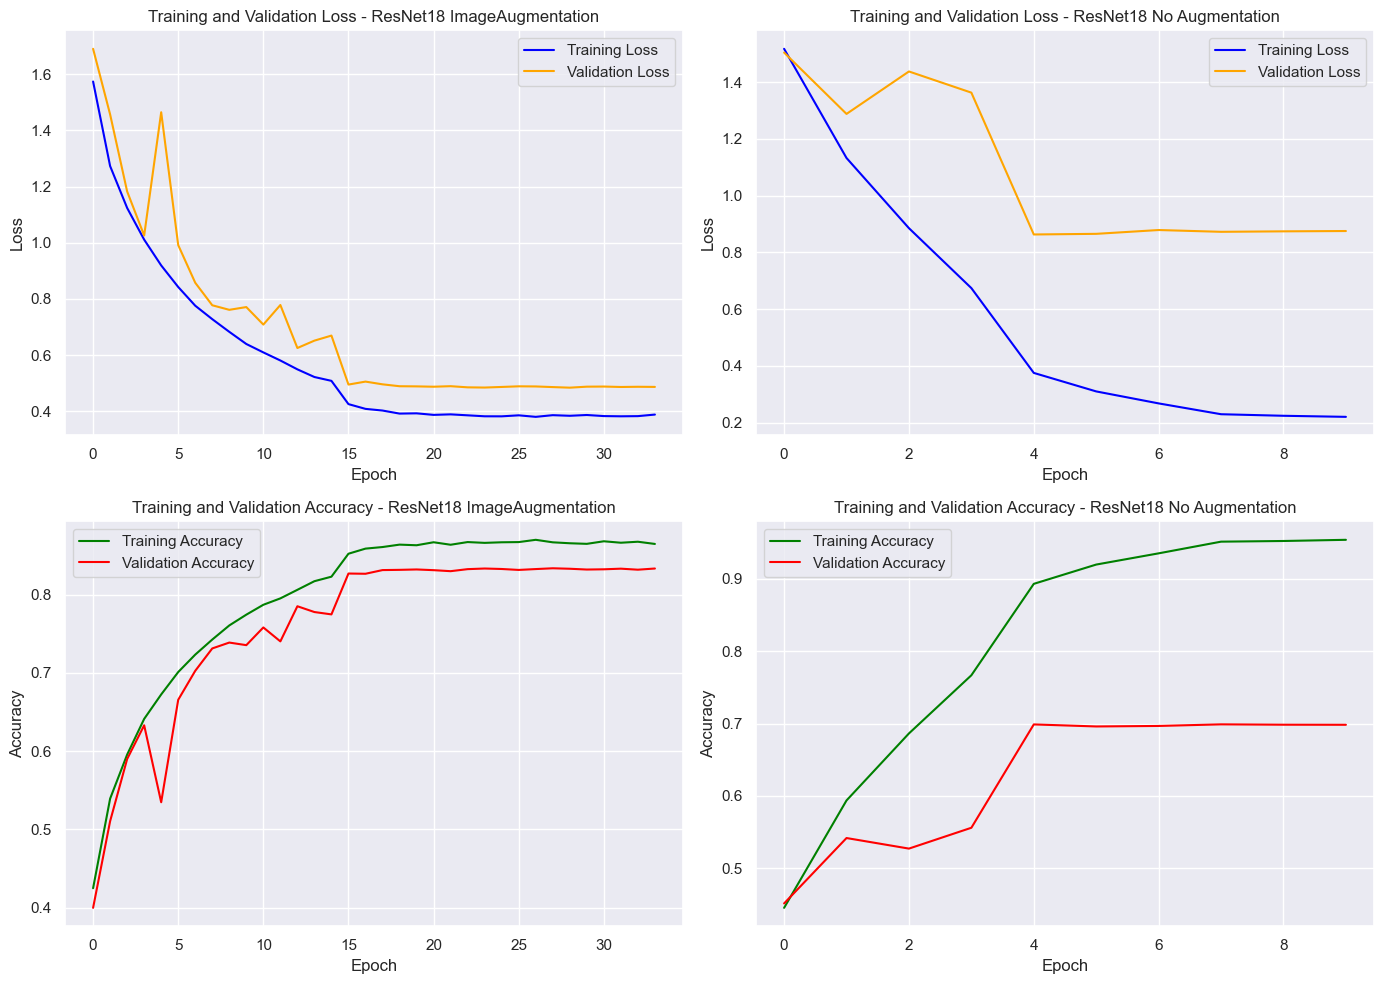

In [12]:
df_with_img_aug = val_result_img_aug[val_result_img_aug['model'] == 'ResNet18 ImageAugmentation']
df_no_aug = val_result_img_aug[val_result_img_aug['model'] == 'ResNet18 No Augmentation']

# Set up side-by-side plots
plt.figure(figsize=(14, 10))

# Plot for ResNet18 ImageAugmentation
plt.subplot(2, 2, 1)
plt.plot(df_with_img_aug['epoch'], df_with_img_aug['train_loss'], label='Training Loss', color='blue')
plt.plot(df_with_img_aug['epoch'], df_with_img_aug['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - ResNet18 ImageAugmentation')
plt.legend()

# Plot for ResNet18 No Augmentation
plt.subplot(2, 2, 2)
plt.plot(df_no_aug['epoch'], df_no_aug['train_loss'], label='Training Loss', color='blue')
plt.plot(df_no_aug['epoch'], df_no_aug['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - ResNet18 No Augmentation')
plt.legend()

# Plot training and validation accuracy for ResNet18 ImageAugmentation
plt.subplot(2, 2, 3)
plt.plot(df_with_img_aug['epoch'], df_with_img_aug['train_accuracy'], label='Training Accuracy', color='green')
plt.plot(df_with_img_aug['epoch'], df_with_img_aug['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - ResNet18 ImageAugmentation')
plt.legend()

# Plot training and validation accuracy for ResNet18 No Augmentation
plt.subplot(2, 2, 4)
plt.plot(df_no_aug['epoch'], df_no_aug['train_accuracy'], label='Training Accuracy', color='green')
plt.plot(df_no_aug['epoch'], df_no_aug['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - ResNet18 No Augmentation')
plt.legend()

# Show the side-by-side plots
plt.tight_layout()
plt.savefig('./ResNet18_no_vs_aug_train_val_loss_accuracy.jpeg', format='jpeg')

plt.show()

The model using image augmentation performs better with higher accuracy and not overfitting

# TRY DIFFERENT OPTIMIZER

In [15]:
image_augmentations = {
        'rotation_range':15,
        'horizontal_flip': True,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
     }

lr = 0.01
optimizers = ['sgd', 'adam']
    
# Data to store results for plotting
results_lr = {
    'epoch': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss':[],
    'model': []
}


for opt in optimizers:
    print(opt)
    model_name_optimizer = f'ResNet18 Optimizer {opt}'
    # model_name_optimizer.append(models)
        
    datagen = ImageDataGenerator(**image_augmentations)
    
    cnn_ResNet18_model = create_resnet18(lr = lr, optimizer=opt)
    epoch_val = 100
    
    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
    mcp_save = keras.callbacks.ModelCheckpoint(f'./ResNet18_model_lr_{lr}.keras', save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-2, mode='min')
    

    history_ResNet18_opt = cnn_ResNet18_model.fit(
        datagen.flow(X_train,y_train, batch_size=64),
        batch_size=64,
        epochs=epoch_val,
        validation_data=(X_valid, y_valid),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
    )

    # Record results for each epoch
    for epoch in range(len(history_ResNet18_opt.history['accuracy'])):
        results_lr['epoch'].append(epoch)
        results_lr['train_accuracy'].append(history_ResNet18_opt.history['accuracy'][epoch])
        results_lr['val_accuracy'].append(history_ResNet18_opt.history['val_accuracy'][epoch])
        results_lr['train_loss'].append(history_ResNet18_opt.history['loss'][epoch])
        results_lr['val_loss'].append(history_ResNet18_opt.history['val_loss'][epoch])
        results_lr['model'].append(model_name_optimizer)

# Convert results to a DataFrame
val_result_opt = pd.DataFrame(results_lr)

sgd
Epoch 1/100


/Users/bernardjohari/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 115ms/step - accuracy: 0.3483 - loss: 1.7788 - val_accuracy: 0.4512 - val_loss: 1.5597 - learning_rate: 0.0100
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - accuracy: 0.5213 - loss: 1.3156 - val_accuracy: 0.4614 - val_loss: 1.5567 - learning_rate: 0.0100
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 111ms/step - accuracy: 0.5884 - loss: 1.1452 - val_accuracy: 0.4744 - val_loss: 1.7928 - learning_rate: 0.0100
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6397 - loss: 1.0116
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.6398 - loss: 1.0115 - val_accuracy: 0.4612 - val_loss: 1.7486 - learning_rate: 0.0100
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.6867 - loss: 0.8753 - val_accuracy: 0.6866 - val_loss: 0.8899 - learning_rate: 1.0000e-03
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 113ms/step - accuracy: 0.7094 

In [16]:
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
val_result_opt.to_csv(f'resnet18_val_result_opt_{current_datetime}.csv', index=False)
display(val_result_opt)

,epoch,train_accuracy,val_accuracy,train_loss,val_loss,model
0,0,0.416475,0.4512,1.585278,1.559695,ResNet18 Optimizer sgd
1,1,0.539175,0.4614,1.271786,1.556728,ResNet18 Optimizer sgd
2,2,0.600825,0.4744,1.111744,1.792774,ResNet18 Optimizer sgd
3,3,0.647600,0.4612,0.988505,1.748606,ResNet18 Optimizer sgd
4,4,0.695125,0.6866,0.855257,0.889891,ResNet18 Optimizer sgd
5,5,0.708275,0.7036,0.821689,0.834439,ResNet18 Optimizer sgd
6,6,0.716350,0.7051,0.806659,0.840515,ResNet18 Optimizer sgd
7,7,0.720925,0.7248,0.791669,0.781794,ResNet18 Optimizer sgd
8,8,0.723050,0.7044,0.785239,0.836244,ResNet18 Optimizer sgd
9,9,0.728875,0.7188,0.774731,0.811976,ResNet18 Optimizer sgd


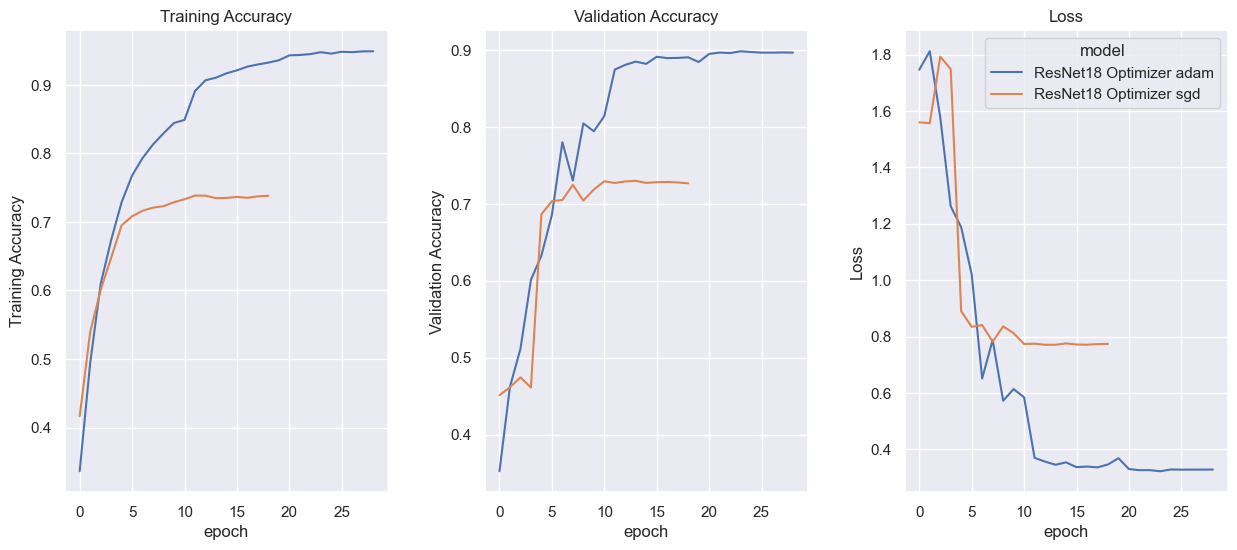

In [17]:

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Define model order for consistent hue ordering
model_order = set(val_result_opt['model'])

# Training Accuracy Plot
sns.lineplot(x="epoch", y="train_accuracy", hue="model", data=val_result_opt,
             ax=ax[0], hue_order=model_order).set(
                 ylabel='Training Accuracy')
ax[0].set_title("Training Accuracy")
ax[0].get_legend().remove()

# Validation Accuracy Plot
sns.lineplot(x="epoch", y="val_accuracy", hue="model", data=val_result_opt,
             ax=ax[1], hue_order=model_order).set(
                 ylabel='Validation Accuracy')
ax[1].set_title("Validation Accuracy")
ax[1].get_legend().remove()

# Loss Plot
sns.lineplot(x="epoch", y="val_loss", hue="model", data=val_result_opt,
             ax=ax[2], hue_order=model_order).set(
                 ylabel='Loss')
ax[2].set_title("Loss")

# Adjust spacing and save the figure
fig.subplots_adjust(wspace=0.3)
fig.savefig('./vgg16_aug_comparison.jpeg', bbox_inches='tight')
plt.show()

# Try different learning rate

In [18]:
image_augmentations = {
        'rotation_range':15,
        'horizontal_flip': True,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
     }

learning_rates = [0.0001, 0.001, 0.01, 0.1]
    
# Data to store results for plotting
results_lr = {
    'epoch': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss':[],
    'model': []
}

for lr in learning_rates:
    model_name = f'ResNet18 LR {lr}'
    print(model_name)
        
    datagen = ImageDataGenerator(**image_augmentations)
    
    cnn_resnet18_model = create_resnet18(lr = lr, optimizer='adam')
    epoch_val = 100
    
    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
    mcp_save = keras.callbacks.ModelCheckpoint(f'./resnet18_model_lr_{lr}.keras', save_best_only=True, monitor='val_loss', mode='min')
    # reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-2, mode='min')
    

    history_resnet18_lr = cnn_resnet18_model.fit(
        datagen.flow(X_train,y_train, batch_size=64),
        batch_size=64,
        epochs=epoch_val,
        validation_data=(X_valid, y_valid),
        callbacks=[earlyStopping, mcp_save]
    )

    # Record results for each epoch
    for epoch in range(len(history_resnet18_lr.history['accuracy'])):
        results_lr['epoch'].append(epoch)
        results_lr['train_accuracy'].append(history_resnet18_lr.history['accuracy'][epoch])
        results_lr['val_accuracy'].append(history_resnet18_lr.history['val_accuracy'][epoch])
        results_lr['train_loss'].append(history_resnet18_lr.history['loss'][epoch])
        results_lr['val_loss'].append(history_resnet18_lr.history['val_loss'][epoch])
        results_lr['model'].append(model_name)

# Convert results to a DataFrame
val_result_lr = pd.DataFrame(results_lr)

ResNet18 LR 0.0001
Epoch 1/100


/Users/bernardjohari/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 222ms/step - accuracy: 0.3937 - loss: 1.6742 - val_accuracy: 0.5521 - val_loss: 1.2702
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 218ms/step - accuracy: 0.5838 - loss: 1.1614 - val_accuracy: 0.5979 - val_loss: 1.1713
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 217ms/step - accuracy: 0.6542 - loss: 0.9755 - val_accuracy: 0.6594 - val_loss: 1.0400
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 220ms/step - accuracy: 0.7035 - loss: 0.8394 - val_accuracy: 0.7071 - val_loss: 0.8387
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 214ms/step - accuracy: 0.7366 - loss: 0.7536 - val_accuracy: 0.7253 - val_loss: 0.8209
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 209ms/step - accuracy: 0.7624 - loss: 0.6820 - val_accuracy: 0.7342 - val_loss: 0.7769
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.7836 - loss: 0.6151 - val_accuracy: 0.7539 - val_loss: 0.7152
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - accuracy: 0.8002 - los

In [19]:
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
val_result_lr.to_csv(f'resnet18_val_result_lr_{current_datetime}.csv', index=False)
display(val_result_lr)

,epoch,train_accuracy,val_accuracy,train_loss,val_loss,model
0,0,0.466450,0.5521,1.465023,1.270182,ResNet18 LR 0.0001
1,1,0.597650,0.5979,1.125048,1.171334,ResNet18 LR 0.0001
2,2,0.663400,0.6594,0.949938,1.040020,ResNet18 LR 0.0001
3,3,0.708625,0.7071,0.828925,0.838674,ResNet18 LR 0.0001
4,4,0.739200,0.7253,0.738473,0.820918,ResNet18 LR 0.0001
...,...,...,...,...,...,...
94,32,0.906000,0.8495,0.278678,0.497604,ResNet18 LR 0.1
95,33,0.908400,0.8413,0.271705,0.533471,ResNet18 LR 0.1
96,34,0.909775,0.8652,0.265365,0.455439,ResNet18 LR 0.1
97,35,0.914275,0.8328,0.256514,0.611109,ResNet18 LR 0.1


In [22]:
max_val_accuracy_per_model = val_result_lr.loc[val_result_lr.groupby('model')['val_accuracy'].idxmax()]

# Display the results
display(max_val_accuracy_per_model)

,epoch,train_accuracy,val_accuracy,train_loss,val_loss,model
16,16,0.886175,0.8497,0.329237,0.453196,ResNet18 LR 0.0001
36,14,0.899700,0.8625,0.286697,0.445468,ResNet18 LR 0.001
60,23,0.920000,0.8646,0.224304,0.465649,ResNet18 LR 0.01
98,36,0.917550,0.8682,0.245957,0.445860,ResNet18 LR 0.1


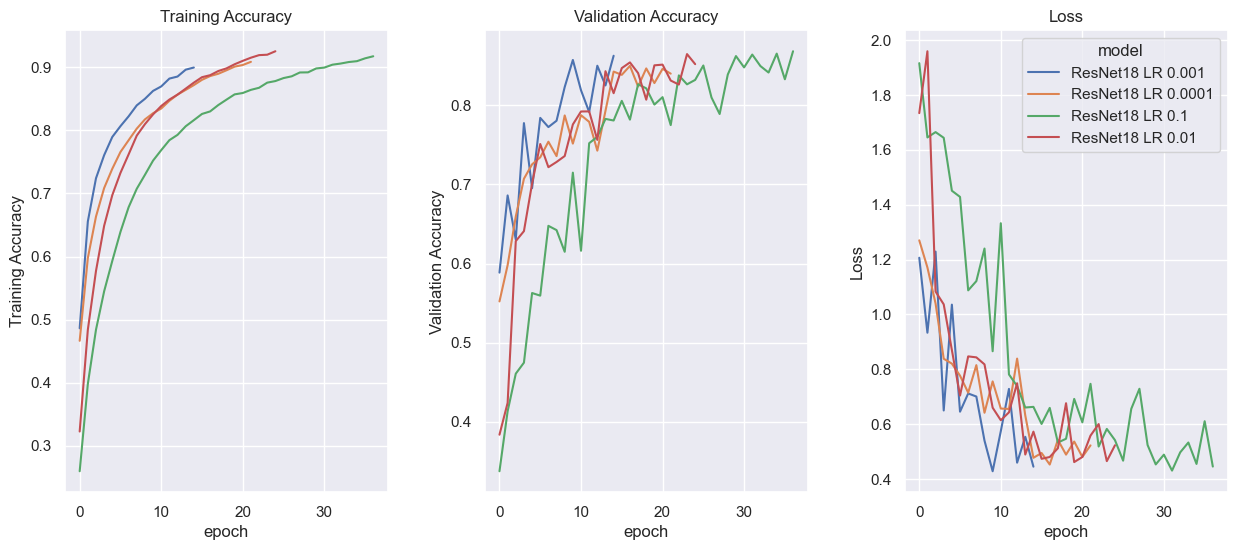

In [20]:
# Plotting
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Define model order for consistent hue ordering
model_order = set(val_result_lr['model'])

# Training Accuracy Plot
sns.lineplot(x="epoch", y="train_accuracy", hue="model", data=val_result_lr,
             ax=ax[0], hue_order=model_order).set(
                 ylabel='Training Accuracy')
ax[0].set_title("Training Accuracy")
ax[0].get_legend().remove()

# Validation Accuracy Plot
sns.lineplot(x="epoch", y="val_accuracy", hue="model", data=val_result_lr,
             ax=ax[1], hue_order=model_order).set(
                 ylabel='Validation Accuracy')
ax[1].set_title("Validation Accuracy")
ax[1].get_legend().remove()

# Loss Plot
sns.lineplot(x="epoch", y="val_loss", hue="model", data=val_result_lr,
             ax=ax[2], hue_order=model_order).set(
                 ylabel='Loss')
ax[2].set_title("Loss")

# Adjust spacing and save the figure
fig.subplots_adjust(wspace=0.3)
fig.savefig('./resnet18_lr_comparison.jpeg', bbox_inches='tight')
plt.show()

In [27]:
cnn_resnet18_model.load_weights('./resnet18_model_lr_0.1.keras')

# Making the Predictions
pred_resnet18 = cnn_resnet18_model.predict(X_test)
# print(pred)

# Converting the predictions into label index 
y_pred_resnet18 = np.argmax(pred_resnet18, axis=1)
print(y_pred_resnet18)
y_pred_classes_resnet18 = [np.argmax(element) for element in y_pred_resnet18]
y_true_classes_resnet18 = np.argmax(y_test, axis=1)

accuracy = (y_pred_resnet18 == y_true_classes_resnet18).sum() * 1.0 / y_test.shape[0]

print('test_accuracy = {}'.format(accuracy))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
[3 8 8 ... 5 1 7]
test_accuracy = 0.866


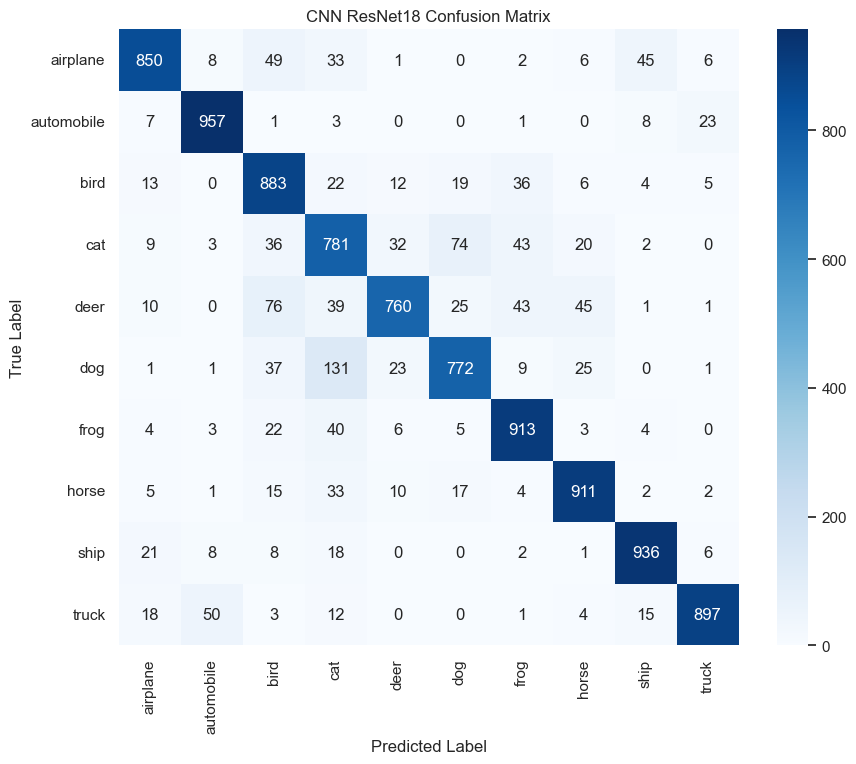

In [32]:
conf_matrix_resnet18_cnn = confusion_matrix(y_true_classes_resnet18, y_pred_resnet18)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_resnet18_cnn,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[classes[i] for i in range(num_classes)],
            yticklabels=[classes[i] for i in range(num_classes)]
            )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN ResNet18 Confusion Matrix')
plt.show()

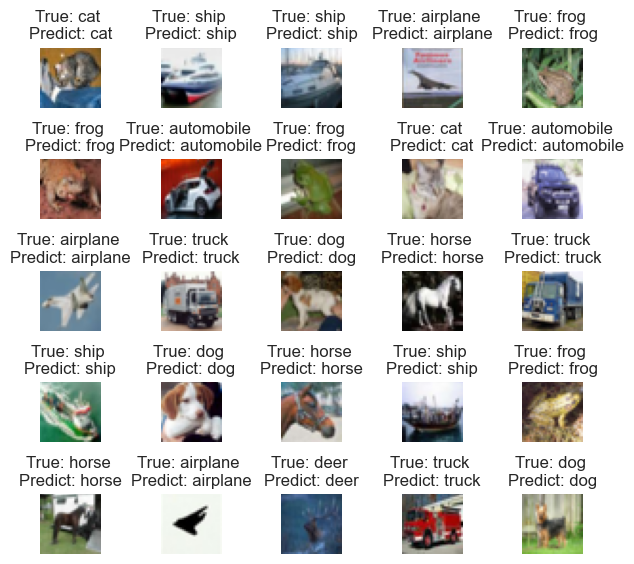

In [33]:
# Plotting the Actual vs. Predicted results

fig, axes = plt.subplots(5, 5, figsize=(7,7))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (classes[np.argmax(y_test[i])], classes[y_pred_resnet18[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

In [34]:
import pandas as pd
import numpy as np
from collections import Counter

# Assuming 'conf_matrix_baseline_cnn' and 'classes' are already defined
class_accuracies = np.diag(conf_matrix_resnet18_cnn) / np.sum(conf_matrix_resnet18_cnn, axis=1)

# Create a DataFrame for class-wise accuracies
accuracy_df = pd.DataFrame({
    'Class': classes,
    'Accuracy': class_accuracies
})

# Find the class with the highest and lowest accuracy
best_class = np.argmax(class_accuracies)
worst_class = np.argmin(class_accuracies)
best_accuracy = class_accuracies[best_class]
worst_accuracy = class_accuracies[worst_class]
median_accuracy = np.median(class_accuracies)
mean_accuracy = np.mean(class_accuracies)

# Create a summary DataFrame for the overall performance
summary_df = pd.DataFrame({
    'Metric': ['Median Accuracy', 'Mean Accuracy', 'Best Class', 'Worst Class'],
    'Value': [median_accuracy, mean_accuracy, classes[best_class], classes[worst_class]]
})

# Extract Misclassifications
misclassifications = []
for true_label in range(10):
    for pred_label in range(10):
        if true_label != pred_label:
            count = conf_matrix_resnet18_cnn[true_label, pred_label]
            if count > 0:
                misclassifications.append((classes[true_label], classes[pred_label], count))

# Count and Sort Misclassifications
misclassification_counter = Counter()
for true_label, pred_label, count in misclassifications:
    misclassification_counter[(true_label, pred_label)] += count

# Get the top 3 most common misclassifications
top_3_errors = misclassification_counter.most_common(3)

# Create a DataFrame for top 3 misclassifications
misclassification_df = pd.DataFrame(top_3_errors, columns=['Misclassification', 'Count'])
misclassification_df['True Class'] = [item[0][0] for item in top_3_errors]
misclassification_df['Predicted Class'] = [item[0][1] for item in top_3_errors]

# Display the DataFrames
print("Class-wise Accuracy Table")
display(accuracy_df)
print('=================================')
print("Overall Model Performance Summary")
display(summary_df)
print('=================================')
print("Top 3 Most Common Misclassifications")
display(misclassification_df)


Class-wise Accuracy Table


,Class,Accuracy
0,airplane,0.850
1,automobile,0.957
2,bird,0.883
3,cat,0.781
4,deer,0.760
5,dog,0.772
6,frog,0.913
7,horse,0.911
8,ship,0.936
9,truck,0.897


Overall Model Performance Summary


,Metric,Value
0,Median Accuracy,0.89
1,Mean Accuracy,0.866
2,Best Class,automobile
3,Worst Class,deer


Top 3 Most Common Misclassifications


,Misclassification,Count,True Class,Predicted Class
0,"(dog, cat)",131,dog,cat
1,"(deer, bird)",76,deer,bird
2,"(cat, dog)",74,cat,dog
